In [1]:
from dotenv import load_dotenv
import os

# Load API key from .env file
load_dotenv("../venv/APIs/.env")
api_key = os.getenv("UNSPLASH_API_KEY")

In [1]:
from torchvision import transforms
from fastai.vision.all import *
from fastbook import *
from fastcore.all import L

In [3]:
import requests
from fastcore.all import L

def search_images_unsplash(term, max_images=30, access_key=None):
    if access_key is None:
        raise ValueError("You must provide an Unsplash Access Key")
        
    url = "https://api.unsplash.com/search/photos"
    images = []
    page = 1
    
    print(f"Searching Unsplash for '{term}'...")
    
    while len(images) < max_images:
        params = {
            "query": term,
            "per_page": 30, # Max allowed per request by Unsplash
            "page": page,
            "client_id": access_key
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            print(f"Error: {response.status_code} - {response.text}")
            break
            
        data = response.json()
        results = data.get('results', [])
        
        if not results: 
            break # No more results found
            
        # Extract just the 'regular' size URL for cleaner usage
        for img in results:
            images.append({'url': img['urls']['regular'], 'alt': img['alt_description']})
            
        page += 1
        
    # Return fastai List, sliced to the exact max_images requested
    return L(images[:max_images])

In [2]:
landscape_types = ['Urban','Coastal','Mountainous','Desert','Forest']
path = Path('Landscapes')

if not path.exists():
    path.mkdir()

In [8]:
import socket
from fastai.vision.utils import download_images

# Set timeout to handle downloads gracefully
socket.setdefaulttimeout(30)

# PASTE YOUR KEY HERE
MY_ACCESS_KEY = api_key

for o in landscape_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    
    try:
        # 1. Search using the Unsplash function
        results = search_images_unsplash(f'{o} landscape', max_images=50, access_key=MY_ACCESS_KEY)
        
        # 2. Download (Note: I named the key 'url' in the function above)
        download_images(dest, urls=results.attrgot('url'), n_workers=4)
        
    except Exception as e:
        print(f"Something went wrong with {o}: {e}")

Searching Unsplash for 'Polluted landscape'...
Searching Unsplash for 'Natural landscape'...
Searching Unsplash for 'Urban landscape'...
Searching Unsplash for 'Coastal landscape'...
Searching Unsplash for 'Mountainous landscape'...
Searching Unsplash for 'Desert landscape'...
Searching Unsplash for 'Forest landscape'...


In [3]:
fns = get_image_files(path)
fns

(#245) [Path('Landscapes/Forest/1e2c4e2c-d5a3-4484-bc8a-b320469298a5.jpg'),Path('Landscapes/Forest/06ad40d5-3a59-4214-8a8e-968cf4a8370c.jpg'),Path('Landscapes/Forest/069f3a30-8b27-47d6-85d3-12ea587145fe.jpg'),Path('Landscapes/Forest/a1f388f2-cc62-4012-9bd9-69720842dfb9.jpg'),Path('Landscapes/Forest/6e2ae539-7610-4c67-ab8c-671c9183b921.jpg'),Path('Landscapes/Forest/53f1f48f-70d9-4708-8728-88bdced296ec.jpg'),Path('Landscapes/Forest/59720c85-64a9-4629-b7fb-5878b9db9353.jpg'),Path('Landscapes/Forest/4c10ae4f-1458-4b45-92f1-f9d9721ec942.jpg'),Path('Landscapes/Forest/2e08f5b1-46b6-4a6d-b474-fdcf83b1dbe6.jpg'),Path('Landscapes/Forest/55ee1bf6-27cd-4a9b-8d3b-7f052f0c2238.jpg'),Path('Landscapes/Forest/339c406a-b622-41d7-bb66-e0c9a9fc5ac4.jpg'),Path('Landscapes/Forest/1bd718e7-0a2b-47c7-ba46-5bc810b557ec.jpg'),Path('Landscapes/Forest/1e0e0ea3-0042-4eeb-87bd-9913b57fb20c.jpg'),Path('Landscapes/Forest/46dfe61c-1e9e-4d98-80df-ee99fab93138.jpg'),Path('Landscapes/Forest/32632650-f3b6-4171-82f4-bd10f7

In [4]:
failed = verify_images(fns)
failed
failed.map(Path.unlink)

(#0) []

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),       # inputs are images, targets are classes
    get_items=get_image_files,                # how to list image paths
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80/20 train/valid split
    get_y=parent_label,                       # derive label from folder name
    item_tfms=Resize(120),                     # resize all images to 96x96
    batch_tfms=Normalize.from_stats(*imagenet_stats)  # normalize pixels
)

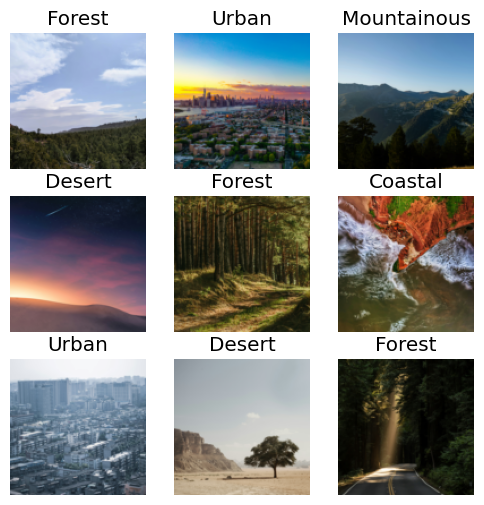

In [6]:
dls = dblock.dataloaders(path, bs=64)
dls.show_batch(max_n=9, figsize=(6,6))

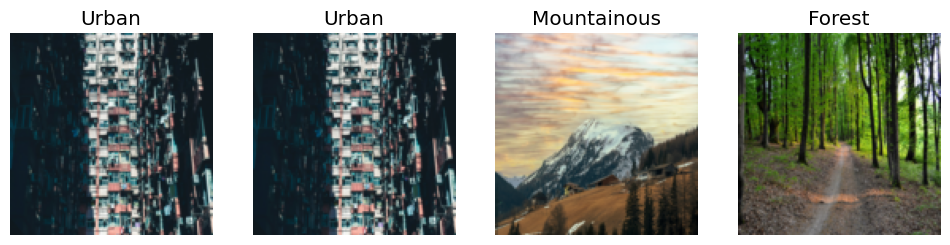

In [7]:
landscapes = dblock.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = landscapes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.817367,1.700093,0.591837,01:40


epoch,train_loss,valid_loss,error_rate,time
0,2.050042,1.308921,0.448980,01:38
1,1.469840,1.143357,0.387755,01:37
2,1.083068,1.033097,0.346939,01:39


In [12]:
learn.export('Models/landscape_classifier.pkl')

RuntimeError: Parent directory Models does not exist.

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

KeyboardInterrupt: 

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [22]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),       # inputs are images, targets are classes
    get_items=get_image_files,                # how to list image paths
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80/20 train/valid split
    get_y=parent_label,                       # derive label from folder name
    item_tfms=Resize(96),                     # resize all images to 96x96
    batch_tfms=Normalize.from_stats(*imagenet_stats)  # normalize pixels
)

dls = dblock.dataloaders(path, bs=64)
golfers = dblock.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = golfers.dataloaders(path)

# Re-initialize the learner with the NEW dls
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.900352,2.605786,0.661017,01:51


epoch,train_loss,valid_loss,error_rate,time
0,1.907640,1.972295,0.559322,01:51
1,1.580877,1.636948,0.440678,01:49
2,1.250804,1.420876,0.457627,01:49
3,1.000486,1.311091,0.406780,01:49


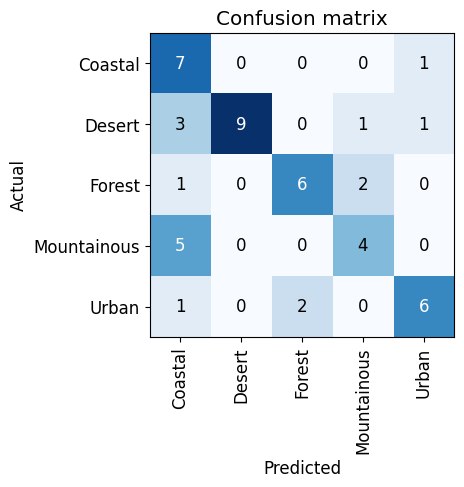

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()